# Plotting Figure 2

This script is used to show multi-model ensemble mean change in UHWs

In [1]:
import xarray as xr
import datetime
import pandas as pd
import numpy as np
#from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import time
import gc
import util
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
# import cartopy.io.shapereader as shapereader

## Step 1: Load 2006 and 2061 data

In [2]:
# Load CMIP
CMIP={}
path="../data/uhws/UHWs_CMIP/"
CMIP["diff_raw"]={}
CMIP["diff_stat"]={}
for year in ["2006","2061"]:
    CMIP[year]={}
    for vari in ["frequency","totaldays","intensity"]:
        CMIP[year][vari]=pd.read_csv(path+year+"_"+vari+".csv").set_index(["lat","lon"])
    CMIP[year]["duration"]=CMIP[year]["totaldays"]/CMIP[year]["frequency"]
    
for vari in ["frequency","totaldays","intensity","duration"]:
    CMIP["diff_raw"][vari] = CMIP["2061"][vari]-CMIP["2006"][vari]
    CMIP["diff_stat"][vari+"_diff_mean"] = CMIP["diff_raw"][vari].mean(axis=1)
    CMIP["diff_stat"][vari+"_diff_std"] = CMIP["diff_raw"][vari].std(axis=1)
    #CMIP["diff_stat"][vari+"_diff_0.025"] = CMIP["diff_raw"][vari].quantile(0.025,axis=1)
    CMIP["diff_stat"][vari+"_diff_SNR"] = CMIP["diff_stat"][vari+"_diff_mean"].abs()/CMIP["diff_stat"][vari+"_diff_std"]

"""
for keys in CMIP["diff_stat"]:
    print(keys)
    print(CMIP["diff_stat"][keys].describe())
"""
# Load CESM
CESM={}
path="../data/uhws/UHWs_CESM/"
CESM["diff_raw"]={}
CESM["diff_stat"]={}
for year in ["2006","2061"]:
    CESM[year]={}
    for vari in ["frequency","totaldays","intensity"]:
        CESM[year][vari]=pd.read_csv(path+year+"_"+vari+".csv").set_index(["lat","lon"])
    CESM[year]["duration"]=CESM[year]["totaldays"]/CESM[year]["frequency"]
    
for vari in ["frequency","totaldays","intensity","duration"]:
    CESM["diff_raw"][vari] = CESM["2061"][vari]-CESM["2006"][vari]
    CESM["diff_stat"][vari+"_diff_mean"] = CESM["diff_raw"][vari].mean(axis=1)
    CESM["diff_stat"][vari+"_diff_std"] = CESM["diff_raw"][vari].std(axis=1)
    #CESM["diff_stat"][vari+"_diff_0.025"] = CESM["diff_raw"][vari].quantile(0.025,axis=1)
    CESM["diff_stat"][vari+"_diff_SNR"] = CESM["diff_stat"][vari+"_diff_mean"].abs()/CESM["diff_stat"][vari+"_diff_std"]

"""
for keys in CESM["diff_stat"]:
    print(keys)
    print(CESM["diff_stat"][keys].describe())
"""

# merge CMIP with CESM member 002
merge_ens={}

for vari in ["frequency","totaldays","intensity","duration"]:
    merge_ens[vari]=pd.concat([CMIP["diff_raw"][vari].reset_index(),
                    CESM["diff_raw"][vari]["002_max"].reset_index()["002_max"]],
                    axis=1).set_index(["lat","lon"])
    merge_ens[vari+"_diff_mean"]=merge_ens[vari].mean(axis=1)
    merge_ens[vari+"_diff_std"]=merge_ens[vari].std(axis=1)
    merge_ens[vari+"_diff_SNR"]=merge_ens[vari+"_diff_mean"].abs()\
                                /merge_ens[vari+"_diff_std"]
#list(merge_ens)

## Step 2: Plotting

In [3]:
def setup_globe(ax):
    ax.set_extent([-180,180,-60,75],crs=ccrs.PlateCarree())
    ax.coastlines(zorder=5)
#     ax.add_feature(cartopy.feature.LAND, facecolor='lightgray',zorder=0)
    ax.add_feature(cartopy.feature.LAKES, facecolor='none',edgecolor='black',
                   linewidth=0.5,zorder=5)
    ax.add_feature(cartopy.feature.BORDERS,
                   facecolor='none',
                   edgecolor='black',
                   linewidth=0.5,zorder=5)

def setup_colorbar_text(ax,p,title_text,var_text):
    ax.set_xlabel("")
    ax.set_ylabel("")
    cbar = plt.colorbar(p, ax=ax,
                    orientation="vertical",
                    fraction=0.1,
                    shrink=0.75,
                    pad=0.02,
                    aspect=30,
                    extend="both")
    g = ax.gridlines(color='grey', linestyle='--', draw_labels=False,zorder=4)
    g.xlocator = mticker.FixedLocator([-90, 0, 90])
    lon_formatter = LongitudeFormatter()#zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    props = dict(boxstyle='round', facecolor='lightcyan')
    # place a text box in upper left in axes coords
    ax.text(0.03, 0.20, var_text, transform=ax.transAxes, fontsize=12,
             verticalalignment='top', bbox=props,zorder=6)
    ax.set_title(title_text, fontweight="bold", loc="left")
    
def plot_scatter(ax,df,SNR,vmin,vmax,cmap):
    df_temp = df.copy()
    df_temp["lon_new"] = np.where(df_temp['lon'] <= 180, 
                                  df_temp['lon'], 
                                  df_temp['lon']-360)
    p = ax.scatter(df_temp["lon"],df_temp["lat"],c=df_temp[0],
                   s=0.5,
                   vmin=vmin,
                   vmax=vmax,
                   cmap=cmap,
                   zorder=3,rasterized=True)
    df_SNR = SNR[SNR[0]>2.0].copy()
    df_SNR["lon_new"] = np.where(df_SNR['lon'] <= 180, 
                                  df_SNR['lon'], 
                                  df_SNR['lon']-360)
    ax.scatter(df_SNR["lon"],df_SNR["lat"],
               s=0.05,c="k",marker=".",
               zorder=3,rasterized=True)
    
    return p
    
def plot_map(df,SNR,i,vmin,vmax,cmap,title_text,var_text):
    ax = plt.subplot(2,2,i+1,projection=ccrs.PlateCarree())
    setup_globe(ax)
    if i==0: 
        ax.set_yticks(np.array([-60,-30,0,30,60]), crs=ccrs.PlateCarree())
    elif i==1:
        pass
    elif i==2:
        ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
        ax.set_yticks(np.array([-60,-30,0,30,60]), crs=ccrs.PlateCarree())
    elif i==3:
        ax.set_xticks(np.linspace(-90, 90, 3), crs=ccrs.PlateCarree())
    p = plot_scatter(ax,df,SNR,vmin,vmax,cmap)
    setup_colorbar_text(ax,p,title_text,var_text) 

intensity


count    4439.000000
mean        1.276472
std         0.485217
min        -0.623549
25%         0.937448
50%         1.225655
75%         1.563328
max         3.605300
dtype: float64

##########################################
frequency


count    4439.000000
mean        5.117350
std         3.209346
min         0.650000
25%         2.988889
50%         3.983333
75%         6.116667
max        19.155556
dtype: float64

##########################################
duration


count    4439.000000
mean        5.405803
std        11.487771
min        -0.182671
25%         2.140971
50%         3.601026
75%         6.144526
max       348.450525
dtype: float64

##########################################
totaldays


count    4439.000000
mean       54.396414
std        47.986746
min         2.529412
25%        25.127778
50%        38.144444
75%        61.494444
max       296.705556
dtype: float64

##########################################


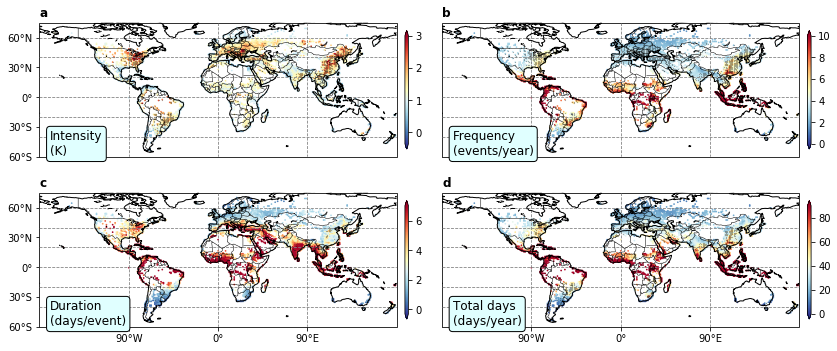

In [4]:
fig = plt.figure(figsize=(12,5))
cmap="RdYlBu_r"
#cmap = "rainbow"

var_list=["intensity","frequency","duration","totaldays"]

max_val={"frequency":10,
         "totaldays":90,
         "intensity":3,
         "duration":7}

min_val={"frequency":0,
         "totaldays":0,
         "intensity":-0.35,
         "duration":-0.3}

var_text_dict={"frequency":"Frequency\n(events/year)",
               "totaldays":"Total days\n(days/year)",
               "intensity":"Intensity\n(K)",
               "duration":"Duration\n(days/event)"}

title_text_dict={"frequency":"b",
                 "totaldays":"d",
                 "intensity":"a",
                 "duration":"c"}


for i in range(4):
    val = var_list[i]
    print(val)  
    df = merge_ens[val+"_diff_mean"]
    SNR = merge_ens[val+"_diff_SNR"].reset_index()[merge_ens["intensity_diff_mean"].reset_index()[0]>1.5]
    display(df.describe())
    plot_map(df.reset_index(),SNR,i,min_val[val], max_val[val],cmap,title_text_dict[val],var_text_dict[val])
    print("##########################################")
    
plt.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig("../figures/uhws.pdf",dpi=188)
plt.show()